In [0]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

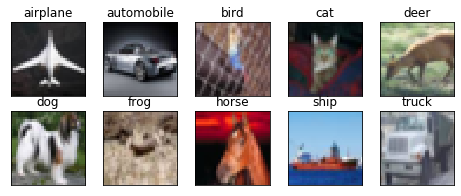

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Gradcam Function

def computeGradCam(model,layerName,inputImage,preProcessedImage,classId = -1): 
	preds = model.predict(preProcessedImage)
	
	if classId == -1:  # use prediction obtained from trained model
		class_idx = np.argmax(preds[0])
	else:
		class_idx = classId
	
	class_output = model.output[:, class_idx]
	conv_layer = model.get_layer(layerName)
	grads = K.gradients(class_output,conv_layer.output)[0]
	pooled_grads = K.mean(grads, axis=(0, 1, 2))
	iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
	pooled_grads_value, conv_layer_output_value = iterate([preProcessedImage])
	
	for i in range(conv_layer.output_shape[3]):
		conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
	
	heatmap = np.mean(conv_layer_output_value, axis=-1)
	heatmap = np.maximum(heatmap, 0)
	heatmap /= np.max(heatmap)    
	heatmap = cv2.resize(heatmap, (inputImage.shape[1], inputImage.shape[0]))
	heatmap = np.uint8(255 * heatmap)
	heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
	superimposed_img = cv2.addWeighted(inputImage, 0.5, heatmap, 0.5, 0, dtype = cv2.CV_32F)
	
	return superimposed_img


In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Part 1 

Load Previous Model (from assignment 6A) and show Gradcam on last layer, second last layer and third last layer. This part includes the code from assignment 9 to develop a model and train on Cifar-10. The same model is tried again with cutout and gradcam results for last 3 layers are shown after cutout

**Load the Model from assignment 6A**

In [9]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(48, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(96, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(192, 3, 3, border_mode='same', name='Third_Last_layer')) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(192, 3, 3)) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(num_classes, 1, name='Second_Last_layer'))
model.add(Convolution2D(num_classes, 2, name='Last_layer'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 48)        192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 48)       

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
390/390 [==============================] - 12s 30ms/step - loss: 1.3083 - acc: 0.5671 - val_loss: 1.2201 - val_acc: 0.5870
Epoch 2/100
390/390 [==============================] - 9s 22ms/step - loss: 0.8660 - acc: 0.7302 - val_loss: 1.0191 - val_acc: 0.6613
Epoch 3/100
390/390 [==============================] - 9s 23ms/step - loss: 0.6778 - acc: 0.7893 - val_loss: 0.8626 - val_acc: 0.7234
Epoch 4/100
390/390 [==============================] - 9s 22ms/step - loss: 0.5628 - acc: 0.8236 - val_loss: 0.7133 - val_acc: 0.7713
Epoch 5/100
390/390 [==============================] - 9s 23ms/step - loss: 0.4727 - acc: 0.8522 - val_loss: 0.8510 - val_acc: 0.7202
Epoch 6/100
390/390 [==============================] - 9s 22ms/step - loss: 0.4038 - acc: 0.8749 - val_loss: 0.7141 - val_acc: 0.7728
Epoch 7/100
390/390 [==============================] - 9s 22ms/step - loss: 0.3445 - acc: 0.8923 - 

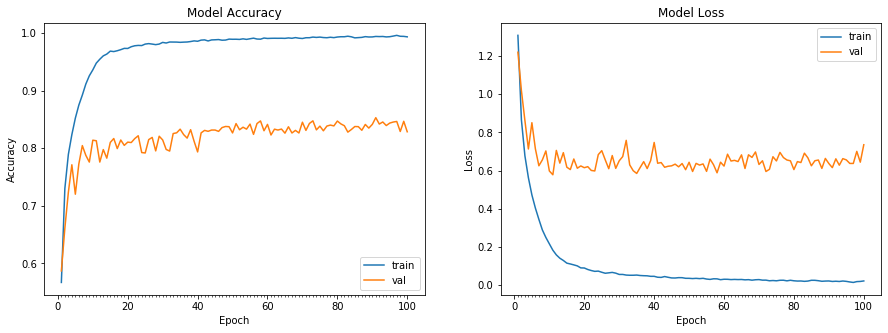

Accuracy on test data is: 82.86


In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

**Reload the data to apply GRAD CAM**

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

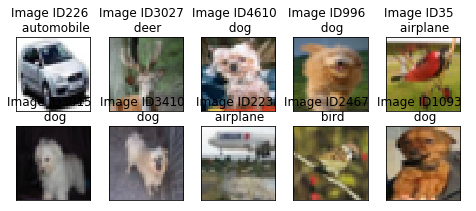

In [13]:
fig = plt.figure(figsize=(8,3))
fig_ids = [226, 3027, 4610, 996, 35, 3015, 3410, 223, 2467, 1093]
count = 0
for i in fig_ids:
    ax = fig.add_subplot(2, 5, 1 + count, xticks=[], yticks=[])
    idx = train_labels[i:][0]
    features_idx = train_features[i,::]
    img_num = i
    im = features_idx
    ax.set_title("Image ID" + str(i) + "  \n " + class_names[int(idx[0])])
    plt.imshow(im)
    count = count + 1
plt.show()

**Apply gradcam on the last Conv Layer**

The complete picture is coloured and this the expected result when applying gradcam on the last layer.

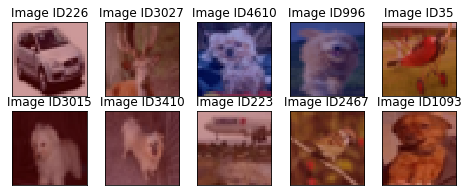

In [14]:
fig = plt.figure(figsize=(8,3))
count = 0
for i in fig_ids: 
  img = train_features[i,::]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("Last_layer")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for j in range(10):
      conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  if (np.max(heatmap) != 0):
    heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)
  ax = fig.add_subplot(2, 5, 1 + count, xticks=[], yticks=[])
  ax.set_title("Image ID" + str(i))
  plt.imshow(superimposed_img.astype('uint8'))
  count = count + 1
plt.show()

**Apply gradcam on the second last Conv Layer**

Few pictures have activation area visible.

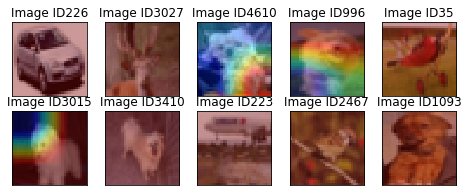

In [15]:
fig = plt.figure(figsize=(8,3))
count = 0
for i in fig_ids: 
  img = train_features[i,::]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("Second_Last_layer")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for j in range(10):
      conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  if (np.max(heatmap) != 0):
    heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)
  ax = fig.add_subplot(2, 5, 1 + count, xticks=[], yticks=[])
  ax.set_title("Image ID" + str(i))
  plt.imshow(superimposed_img.astype('uint8'))
  count = count + 1
plt.show()

**Apply gradcam on the third last Conv Layer**

The activation area is highlighted in most of the images and this is the expected result when applying gradcam.

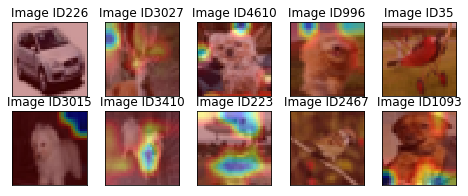

In [16]:

fig = plt.figure(figsize=(8,3))
count = 0
for i in fig_ids: 
  img = train_features[i,::]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("Third_Last_layer")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for j in range(192):
      conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  if (np.max(heatmap) != 0):
    heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)
  ax = fig.add_subplot(2, 5, 1 + count, xticks=[], yticks=[])
  ax.set_title("Image ID" + str(i))
  plt.imshow(superimposed_img.astype('uint8'))
  count = count + 1
plt.show()

**Apply cutout and then apply GRAD CAM**

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

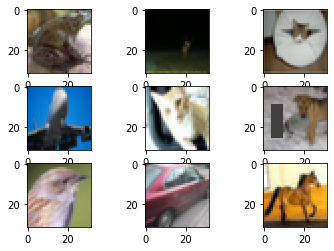

In [18]:
eraser = get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False)

datagen = ImageDataGenerator(zoom_range=0.0, horizontal_flip=False, 
                             preprocessing_function = eraser)

datagen.fit(train_features)

it = datagen.flow(train_features, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [20]:
# Define the model
cutout_model = Sequential()
cutout_model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
cutout_model.add(Activation('relu'))
cutout_model.add(BatchNormalization())
cutout_model.add(Convolution2D(48, 3, 3))
cutout_model.add(Activation('relu'))
cutout_model.add(BatchNormalization())
cutout_model.add(Dropout(0.25))
cutout_model.add(MaxPooling2D(pool_size=(2, 2)))
cutout_model.add(Convolution2D(96, 3, 3, border_mode='same'))
cutout_model.add(Activation('relu'))
cutout_model.add(BatchNormalization())
cutout_model.add(Convolution2D(96, 3, 3))
cutout_model.add(Activation('relu'))
cutout_model.add(BatchNormalization())
cutout_model.add(Dropout(0.25))
cutout_model.add(MaxPooling2D(pool_size=(2, 2)))
cutout_model.add(Convolution2D(192, 3, 3, border_mode='same', name='Third_Last_layer')) 
cutout_model.add(Activation('relu'))
cutout_model.add(BatchNormalization())
cutout_model.add(Convolution2D(192, 3, 3)) 
cutout_model.add(Activation('relu'))
cutout_model.add(BatchNormalization())
cutout_model.add(Dropout(0.25))
cutout_model.add(MaxPooling2D(pool_size=(2, 2)))
cutout_model.add(Convolution2D(num_classes, 1, name='Second_Last_layer'))
cutout_model.add(Convolution2D(num_classes, 2, name='Last_layer'))
cutout_model.add(BatchNormalization())
cutout_model.add(Flatten())
cutout_model.add(Activation('softmax'))

# Compile the cutout_model
cutout_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cutout_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_9 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 48)        192       
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 48)       

Epoch 1/100
390/390 [==============================] - 11s 28ms/step - loss: 1.9864 - acc: 0.2663 - val_loss: 2.4346 - val_acc: 0.1018
Epoch 2/100
390/390 [==============================] - 9s 22ms/step - loss: 1.5118 - acc: 0.4668 - val_loss: 2.3703 - val_acc: 0.1909
Epoch 3/100
390/390 [==============================] - 9s 22ms/step - loss: 1.2609 - acc: 0.5644 - val_loss: 2.1230 - val_acc: 0.2435
Epoch 4/100
390/390 [==============================] - 9s 23ms/step - loss: 1.0795 - acc: 0.6319 - val_loss: 1.7345 - val_acc: 0.3780
Epoch 5/100
390/390 [==============================] - 9s 22ms/step - loss: 0.9498 - acc: 0.6772 - val_loss: 1.1162 - val_acc: 0.6221
Epoch 6/100
390/390 [==============================] - 9s 22ms/step - loss: 0.8593 - acc: 0.7086 - val_loss: 0.9056 - val_acc: 0.6974
Epoch 7/100
390/390 [==============================] - 9s 22ms/step - loss: 0.7847 - acc: 0.7343 - val_loss: 1.0972 - val_acc: 0.6220
Epoch 8/100
390/390 [==============================] - 9s 22m

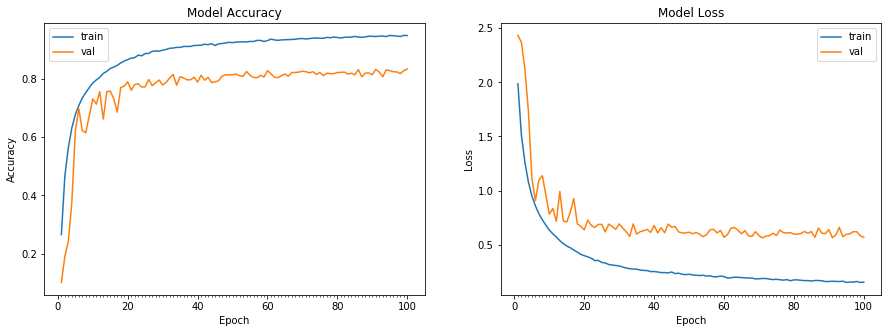

Accuracy on test data is: 82.86


In [21]:
from keras.preprocessing.image import ImageDataGenerator

eraser = get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False)

datagen = ImageDataGenerator(zoom_range=0.0, horizontal_flip=False, 
                             preprocessing_function = eraser)

# train the model
start = time.time()
# Train the model
model_info = cutout_model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

from keras.preprocessing import image

**Apply gradcam on the last Conv Layer**

The complete picture is coloured and this the expected result when applying gradcam on the last layer in this kind of model.

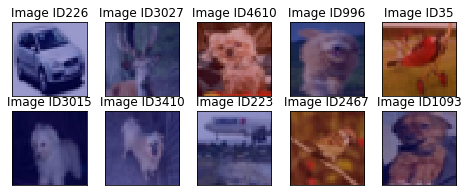

In [23]:
fig = plt.figure(figsize=(8,3))
count = 0
for i in fig_ids: 
  img = train_features[i,::]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  preds = cutout_model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = cutout_model.output[:, class_idx]
  last_conv_layer = cutout_model.get_layer("Last_layer")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([cutout_model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for j in range(10):
      conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  if (np.max(heatmap) != 0):
    heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)
  ax = fig.add_subplot(2, 5, 1 + count, xticks=[], yticks=[])
  ax.set_title("Image ID" + str(i))
  plt.imshow(superimposed_img.astype('uint8'))
  count = count + 1
plt.show()

**Apply gradcam on the second last Conv Layer**

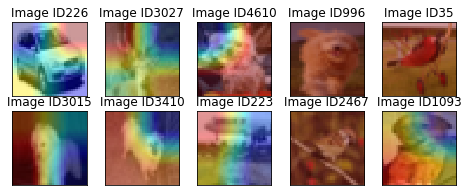

In [24]:
fig = plt.figure(figsize=(8,3))
count = 0
for i in fig_ids: 
  img = train_features[i,::]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  preds = cutout_model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = cutout_model.output[:, class_idx]
  last_conv_layer = cutout_model.get_layer("Second_Last_layer")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([cutout_model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for j in range(10):
      conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  if (np.max(heatmap) != 0):
    heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)
  ax = fig.add_subplot(2, 5, 1 + count, xticks=[], yticks=[])
  ax.set_title("Image ID" + str(i))
  plt.imshow(superimposed_img.astype('uint8'))
  count = count + 1
plt.show()

**Apply gradcam on the third last Conv Layer**

The activation area is highlighted and this the expected result when applying gradcam on the third last layer.

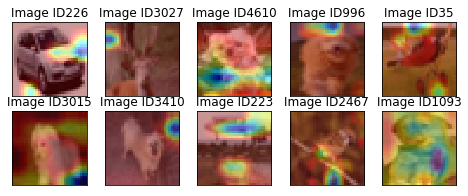

In [25]:

fig = plt.figure(figsize=(8,3))
count = 0
for i in fig_ids: 
  img = train_features[i,::]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  preds = cutout_model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = cutout_model.output[:, class_idx]
  last_conv_layer = cutout_model.get_layer("Third_Last_layer")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([cutout_model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for j in range(192):
      conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  if (np.max(heatmap) != 0):
    heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)
  ax = fig.add_subplot(2, 5, 1 + count, xticks=[], yticks=[])
  ax.set_title("Image ID" + str(i))
  plt.imshow(superimposed_img.astype('uint8'))
  count = count + 1
plt.show()

# Part 2

Load the trained VGG Model and the image given. Apply gradcam on last 3 layers to identify Sun Glasses.

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

vgg_model = VGG16(weights="imagenet")

In [27]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
last_conv_layer_name = "block5_conv3"
second_last_layer_name = "block5_conv2"
third_last_layer_name = "block5_conv1"

Find the class id for the Sunglass

In [29]:
import json
from keras.utils.data_utils import get_file
CLASS_INDEX_PATH = ('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models',file_hash='c2c37ea517e94d9795004a39431a14cb')
with open(fpath) as f:
  CLASS_INDEX = json.load(f)

# Now Search for 'sunglasses' class name and estimate its class id
classId = [classId for classId, classDetail in CLASS_INDEX.items() if classDetail[1] == 'sunglasses']
sunGlassesClassId = classId[0]
print(sunGlassesClassId)  

837


In [30]:
!pip install Pillow
from skimage import io
from PIL import Image
import requests

# Fetch the image from given url and load it
url = 'https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'
inImage = Image.open(requests.get(url, stream=True).raw)
inImage = np.array(inImage)
inImage = cv2.resize(inImage, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(inImage)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Gradcam applied on the last layer

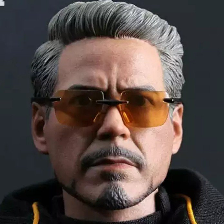

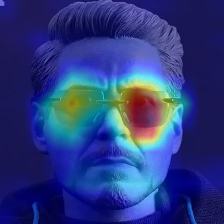

In [31]:
supImg_lastLayer = computeGradCam(vgg_model,last_conv_layer_name,inImage,x,int(sunGlassesClassId))
cv2_imshow(cv2.cvtColor(inImage, cv2.COLOR_RGB2BGR))
cv2_imshow(supImg_lastLayer)

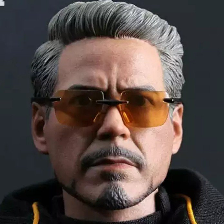

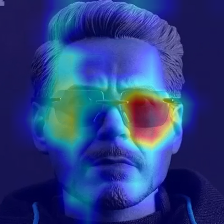

In [32]:
supImg_lastLayer = computeGradCam(vgg_model,second_last_layer_name,inImage,x,int(sunGlassesClassId))
cv2_imshow(cv2.cvtColor(inImage, cv2.COLOR_RGB2BGR))
cv2_imshow(supImg_lastLayer)

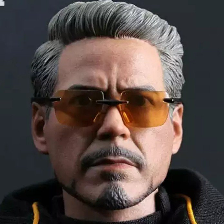

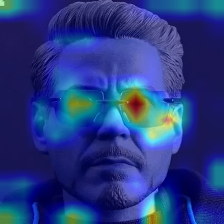

In [33]:
supImg_lastLayer = computeGradCam(vgg_model,third_last_layer_name,inImage,x,int(sunGlassesClassId))
cv2_imshow(cv2.cvtColor(inImage, cv2.COLOR_RGB2BGR))
cv2_imshow(supImg_lastLayer)

# Part 3

This part will contain the calculation. I am currently working on that. I will complete and add new notebook on github before 15th Dec. The link to assignment will not change.